In [1]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_histogram
from qiskit import Aer, transpile

import numpy as np
import matplotlib.pyplot as plt

simulator = Aer.get_backend('aer_simulator', device="CPU")

In [2]:
def majority_bit(bits_string:str) -> int:
    return 1 if bits_string.count('1') >= bits_string.count('0') else 0

In [3]:
N = 3
# List of all the N bits-strings
bits_strings = [format(i, '0'+str(N)+'b') for i in range(2**N)]
print(bits_strings)

['000', '001', '010', '011', '100', '101', '110', '111']


In [4]:
# randomly select 3/4 of the bit-strings
rand_bits = bits_strings.copy()
np.random.shuffle(rand_bits)
selected_bits_strings = rand_bits[:int(3/4*len(bits_strings))]
print(selected_bits_strings)

['000', '011', '110', '010', '111', '101']


In [5]:
# Create the encoder circuit
def encoder_circuit(bits_string:str) -> QuantumCircuit:
    qc = QuantumCircuit(N, name='encoder')
    for i, bit in enumerate(bits_string):
        if bit == '1':
            qc.x(N-1-i)
        qc.h(N-1-i)
    return qc

c:\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


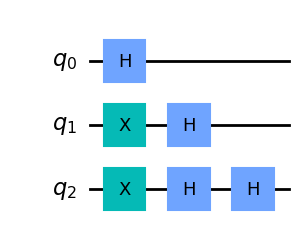

In [6]:
encoder_circuit('1100').draw('mpl')

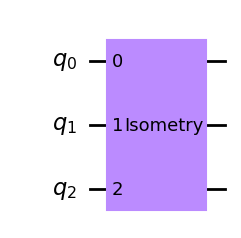

In [7]:
def hamiltonian():
    # Create an highly entangled hamiltonian
    H = np.zeros((2**N, 2**N))
    for i in range(2**N):
        for j in range(2**N):
            H[i, j] = 1/(i+1) + 1/(j+1)

    return H

# Create the entanglement circuit
def entanglement_circuit() -> QuantumCircuit:
    H = hamiltonian()
    t = 0.7

    diag, eigen_vecs = np.linalg.eigh(H)
    time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*t*diag))), eigen_vecs.T.conj()) # e^-iHT

    qc = QuantumCircuit(N, name='entanglement')

    qc.iso(time_evol_op, list(range(N)), [])

    return qc

entanglement_circuit().draw('mpl')

In [8]:
def parameterized_circuit(*angles) -> QuantumCircuit:
    qc = QuantumCircuit(N, name='parameterized')
    for i in range(N):
        qc.rx(angles[3*i], i)
        qc.rz(angles[3*i+1], i)
        qc.rx(angles[3*i+2], i)
    return qc

In [9]:
# create a 3N random angles array
init_angles = np.random.rand(3*N)*2*np.pi
init_angles

array([3.20704492, 4.62753915, 1.38266989, 5.3469396 , 4.23490508,
       0.82643713, 4.56739891, 3.33838708, 1.43940491])

In [10]:
def all_circuits(bits_string:str, *angles) -> dict:
    qc = QuantumCircuit(N, name='all')
    qc.append(encoder_circuit(bits_string), range(N))
    qc.append(entanglement_circuit(), range(N))
    qc.append(parameterized_circuit(*angles), range(N))
    qc.measure_all()
    qc = transpile(qc, simulator)
    counts = execute(qc, simulator).result().get_counts()
    return counts

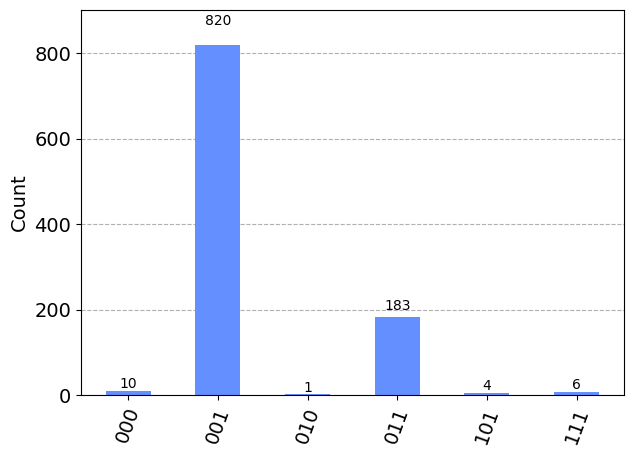

In [11]:
plot_histogram(all_circuits('1100', *init_angles))

In [12]:
def cost_function(bits_string:str, *angles) -> float:
    counts = all_circuits(bits_string, *angles)
    expectation = majority_bit(bits_string)
    good_res = 0
    for bit_string, count in counts.items():
        if expectation == 0:
            good_res += count if int(bit_string, 2) < int(2**N)/2 else 0
        else:
            good_res += count if int(bit_string, 2) > int(2**N)/2 else 0

    return 1 - good_res/sum(counts.values())

In [13]:
cost_function('1100', *init_angles)

0.98828125

In [14]:
def train_circuit(iterations:int, learning_rate:float) -> np.ndarray:
    angles = init_angles.copy()
    for it in range(iterations):
        print(f'Iteration {it+1}/{iterations}')
        for bits_string in selected_bits_strings:
            print(f'Bits string: {bits_string}, Position {selected_bits_strings.index(bits_string)+1}/{len(selected_bits_strings)}')
            gradient = np.zeros(3*N)
            for i in range(3*N):
                angles[i] += np.pi/2
                cost_plus = cost_function(bits_string, *angles)
                angles[i] -= np.pi
                cost_minus = cost_function(bits_string, *angles)
                angles[i] += np.pi/2
                gradient[i] = (cost_plus - cost_minus)/2
                print(f'Gradient {i+1}/{3*N}')
                print(f'Current cost: {cost_plus}')
                print(f'Gradient: {gradient[i]}')
            angles -= learning_rate*gradient
    return angles

In [15]:
trained = train_circuit(5, 0.1)
trained

Iteration 1/5
Bits string: 000, Position 1/6
Gradient 1/9
Current cost: 0.7314453125
Gradient: -0.009765625
Gradient 2/9
Current cost: 0.76953125
Gradient: 0.00390625
Gradient 3/9
Current cost: 0.763671875
Gradient: 0.0126953125
Gradient 4/9
Current cost: 0.7626953125
Gradient: 0.00634765625
Gradient 5/9
Current cost: 0.7431640625
Gradient: -0.00830078125
Gradient 6/9
Current cost: 0.75390625
Gradient: -0.00146484375
Gradient 7/9
Current cost: 0.375
Gradient: -0.2001953125
Gradient 8/9
Current cost: 0.7998046875
Gradient: 0.33251953125
Gradient 9/9
Current cost: 0.7236328125
Gradient: 0.21826171875
Bits string: 011, Position 2/6
Gradient 1/9
Current cost: 0.845703125
Gradient: 0.00390625
Gradient 2/9
Current cost: 0.6181640625
Gradient: -0.03857421875
Gradient 3/9
Current cost: 0.650390625
Gradient: 0.01220703125
Gradient 4/9
Current cost: 0.8818359375
Gradient: 0.0009765625
Gradient 5/9
Current cost: 0.794921875
Gradient: 0.09716796875
Gradient 6/9
Current cost: 0.8935546875
Gradient:

array([3.20533594, 4.65546883, 1.41548239, 5.35275015, 4.20634063,
       0.75890783, 4.77511375, 2.55840662, 1.25307679])

In [16]:
for bits_string in bits_strings:
    print(f'Cost for {bits_string} (in data {bits_string in selected_bits_strings}): {cost_function(bits_string, *trained)}')

Cost for 000 (in data True): 0.361328125
Cost for 001 (in data False): 0.2236328125
Cost for 010 (in data True): 0.2138671875
Cost for 011 (in data True): 0.921875
Cost for 100 (in data False): 0.638671875
Cost for 101 (in data True): 0.388671875
Cost for 110 (in data True): 0.2373046875
Cost for 111 (in data True): 0.7978515625


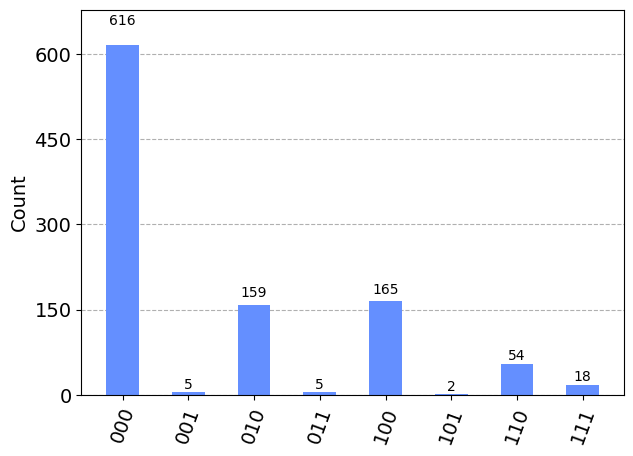

In [20]:
plot_histogram(all_circuits('011', *trained))